In [0]:
import numpy as np
import math
from typing import List
import os
import argparse
import glob
import shutil
from torchvision import transforms
import torchvision.datasets as datasets
import torch.utils.data as loader
from torchvision import models
import torch
import torch.nn as nn
import time
import torch.optim as optim
from PIL import Image
import requests
import matplotlib.pyplot as plt


In [3]:
! wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

--2020-03-20 13:34:48--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125.64M  16.5MB/s    in 6.8s    

2020-03-20 13:34:55 (18.4 MB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]



In [4]:
!tar -xvzf ./101_ObjectCategories.tar.gz 

Streaming output truncated to the last 5000 lines.
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectCategories/chair/image_0031.jpg
101_ObjectCategories/chai

In [0]:

# Get all files in the current directory
def list_files(path):
    files = os.listdir(path)
    return np.asarray(files)

def split_files(oldpath, newpath, classes):
    for name in classes:
        full_dir = os.path.join(os.getcwd(), f"{oldpath}/{name}")

        files = list_files(full_dir)
        total_file = np.size(files,0)
        # We split data set into 3: train, validation and test
        
        train_size = math.ceil(total_file * 3/4) # 75% for training 

        validation_size = train_size + math.ceil(total_file * 1/8) # 12.5% for validation
        test_size = validation_size + math.ceil(total_file * 1/8) # 12.5x% for testing 
        
        train = files[0:train_size]
        validation = files[train_size:validation_size]
        test = files[validation_size:]

        move_files(train, full_dir, f"train/{name}")
        move_files(validation, full_dir, f"validation/{name}")
        move_files(test, full_dir, f"test/{name}")

def move_files(files, old_dir, new_dir):
    new_dir = os.path.join(os.getcwd(), new_dir);
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    for file in np.nditer(files):
        old_file_path = os.path.join(os.getcwd(), f"{old_dir}/{file}")
        new_file_path = os.path.join(os.getcwd(), f"{new_dir}/{file}")

        shutil.move(old_file_path, new_file_path)


In [0]:
newpath ='./'
classes = ['Leopards', 'airplanes', 'butterfly', 'camera', 'elephant', 'lamp', 'watch', 'umbrella', 'rhino'];

split_files('101_ObjectCategories', './', classes)

In [0]:

image_transforms = {
    'train': transforms.Compose([
              transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
              transforms.RandomRotation(degrees=15),
              transforms.RandomHorizontalFlip(),
              transforms.CenterCrop(size=224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
             transforms.Resize(size=256),
             transforms.CenterCrop(size=224),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])              
    ]),
    'test': transforms.Compose([
             transforms.Resize(size=256),
             transforms.CenterCrop(size=224),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])              
    ])
}

In [0]:
# Create iterator for the data loader using DataLoader module

batch_size = 10

data = {
    'train': datasets.ImageFolder(root='./train', transform=image_transforms['train']),
    'validation': datasets.ImageFolder(root='./validation',transform=image_transforms['validation']),
    'test': datasets.ImageFolder(root='./test', transform=image_transforms['test'])
}


In [0]:
train_data = loader.DataLoader(data['train'], batch_size=batch_size, shuffle=True)
validation_data = loader.DataLoader(data['validation'], batch_size=batch_size, shuffle=True)
test_data = loader.DataLoader(data['test'], batch_size=batch_size, shuffle=True)

# Get size of data to be used for calculating loss

train_data_size = len(data['train'])
validation_data_size = len(data['validation'])
test_data_size =  len(data['test'])

In [10]:
train_data_size, validation_data_size, test_data_size

(1233, 208, 198)

In [11]:

model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
# Change the final layer of ResNet50 Model for Transfer Learning
for param in model.parameters():
  param.requires_grad = False
 
fc_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 2048),
    nn.ReLU(inplace=True),
    nn.Linear(2048, 10),
    nn.Dropout(0.4),
    nn.LogSoftmax(dim=1)
)


In [0]:
# Convert model to be used on GPU in cuda is available
if(torch.cuda.is_available()):
    model = model.to("cuda")

In [0]:
# Define Optimizer and Loss function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [0]:
# Calculate loss and accuracy
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
  
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  start = time.time()
  history = []
  best_acc = 0.0

  for epoch in range(epochs):
    epoch_start = time.time()
    print(f'Epoch : {epoch+1}/{epochs}')

    model.train()

    train_loss = 0.0 
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc  = 0.0

    for i, (inputs, labels) in enumerate(train_data):

      inputs = inputs.to(device)
      labels = labels.to(device)

      # Clean existing gradients

      optimizer.zero_grad()

      # Forward pass - compute outputs on input data using the model
      outputs = model(inputs)

      # Compute loss
      loss = loss_criterion(outputs, labels)

      # Backpropagate the gradients

      loss.backward()

      # Update the parameters
      optimizer.step()

      # Compute the total loss for the batch and it to train_loss

      train_loss += loss.item() * inputs.size(0)

      # Compute the accuracy

      ret, predictions = torch.max(outputs.data,1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))

      # Convert correct_counts to float and then compute the mean

      acc = torch.mean(correct_counts.type(torch.FloatTensor))

      # Compute total accuracy in the whole batch and add to train_acc

      train_acc += acc.item() * inputs.size(0)

      print(f'Batch number: {i}, Training: Loss: {loss.item()}, Accuracy: {acc.item()}')

    with torch.no_grad():
      
      model.eval()

      for j, (inputs, labels) in enumerate(validation_data):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        loss = loss_criterion(outputs, labels)

        # Compute the total loss for  the batch and add it to valid_loss

        valid_loss += loss.item() * inputs.size(0)
        
        # Calculate validation accuracy

        ret, predictions = torch.max(outputs.data, 1)
        correct_prediction_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_prediction_counts to float and then compute the mean

        acc = torch.mean(correct_prediction_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to valid_acc

        valid_acc +=acc.item() * inputs.size(0)
      

      avg_train_loss = train_loss/train_data_size
      avg_train_acc = train_acc/train_data_size

      avg_valid_loss = valid_loss/validation_data_size
      avg_valid_acc = valid_acc/validation_data_size

      history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

      epoch_end = time.time()
    
      print(f'Epoch : {epoch}, Training: Loss: f{avg_train_loss}, Accuracy: {avg_train_acc*100}%, \n\t\tValidation : Loss : {avg_valid_loss}, Accuracy: {avg_valid_acc*100}%, Time: {epoch_end-epoch_start}s')
      
      # Save if the model has best accuracy till now

      torch.save(model.state_dict(), f'model_{epoch}.pth')
    
    return model, history

In [16]:
num_epochs = 30
trained_model, history = train_and_validate(model, loss_func, optimizer, num_epochs)

Epoch : 1/30
Batch number: 0, Training: Loss: 2.3356409072875977, Accuracy: 0.10000000149011612
Batch number: 1, Training: Loss: 2.3776955604553223, Accuracy: 0.5
Batch number: 2, Training: Loss: 2.8357784748077393, Accuracy: 0.30000001192092896
Batch number: 3, Training: Loss: 5.384062767028809, Accuracy: 0.20000000298023224
Batch number: 4, Training: Loss: 3.7279059886932373, Accuracy: 0.4000000059604645
Batch number: 5, Training: Loss: 3.1865344047546387, Accuracy: 0.4000000059604645
Batch number: 6, Training: Loss: 6.493165016174316, Accuracy: 0.0
Batch number: 7, Training: Loss: 3.7146801948547363, Accuracy: 0.0
Batch number: 8, Training: Loss: 3.1360702514648438, Accuracy: 0.30000001192092896
Batch number: 9, Training: Loss: 2.107013702392578, Accuracy: 0.6000000238418579
Batch number: 10, Training: Loss: 3.1781201362609863, Accuracy: 0.30000001192092896
Batch number: 11, Training: Loss: 1.8311882019042969, Accuracy: 0.6000000238418579
Batch number: 12, Training: Loss: 2.59898805

In [0]:

def computeModelAccuracy(model, loss_criterion):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  
  test_acc = 0.0
  test_loss = 0.0

  with torch.no_grad():

    # Set to evaluation mode
    model.eval()

    for i, (inputs, labels) in enumerate(test_data):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      # Compute loss
      loss = loss_criterion(outputs, labels)

      # Compute the toal loss item 
      test_loss += loss.item() * inputs.size(0)

      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))

      acc = torch.mean(correct_counts.type(torch.FloatTensor))

      test_acc +=acc.item() * inputs.size(0)

      print(f'Test Batch number: {i}, Test: Loss: {loss.item()}, Accuracy: {acc.item()}')

      # Find average test loss and test accuracy
      avg_test_loss = test_loss/test_data_size
      avg_test_acc = test_acc/test_data_size

      print(f'Test accuracy: {avg_test_acc}')
  

In [18]:
model = models.resnet50(pretrained=False)
fc_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 2048),
    nn.ReLU(inplace=True),
    nn.Linear(2048, 10),
    nn.Dropout(0.4),
    nn.LogSoftmax(dim=1))

if(torch.cuda.is_available()):
    model = model.to("cuda")
model.load_state_dict(torch.load('model_0.pth'))

computeModelAccuracy(model, loss_func)

Test Batch number: 0, Test: Loss: 0.13436883687973022, Accuracy: 1.0
Test accuracy: 0.050505050505050504
Test Batch number: 1, Test: Loss: 0.29125505685806274, Accuracy: 0.8999999761581421
Test accuracy: 0.09595959475546172
Test Batch number: 2, Test: Loss: 0.17531020939350128, Accuracy: 1.0
Test accuracy: 0.14646464526051223
Test Batch number: 3, Test: Loss: 0.33547988533973694, Accuracy: 1.0
Test accuracy: 0.19696969576556272
Test Batch number: 4, Test: Loss: 0.08712837845087051, Accuracy: 1.0
Test accuracy: 0.24747474627061325
Test Batch number: 5, Test: Loss: 0.16974905133247375, Accuracy: 0.8999999761581421
Test accuracy: 0.29292929052102445
Test Batch number: 6, Test: Loss: 0.14866268634796143, Accuracy: 0.8999999761581421
Test accuracy: 0.3383838347714357
Test Batch number: 7, Test: Loss: 0.3429982364177704, Accuracy: 1.0
Test accuracy: 0.3888888852764862
Test Batch number: 8, Test: Loss: 0.08392546325922012, Accuracy: 1.0
Test accuracy: 0.4393939357815367
Test Batch number: 9, 

In [19]:

index_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print (index_to_class)

def makePrediction(model, url):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = image_transforms['test']

    test_image = Image.open(requests.get(url, stream=True).raw)

    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.view(1, 3, 224, 224).to(device)
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print(f"Prediction {i+1} : {index_to_class[topclass.cpu().numpy()[0][i]]}, Score: {topk.cpu().numpy()[0][i] * 100}%")

{0: 'Leopards', 1: 'airplanes', 2: 'butterfly', 3: 'camera', 4: 'elephant', 5: 'lamp', 6: 'rhino', 7: 'umbrella', 8: 'watch'}


Prediction 1 : Leopards, Score: 98.18728566169739%
Prediction 2 : rhino, Score: 0.4736891947686672%
Prediction 3 : butterfly, Score: 0.36402614787220955%


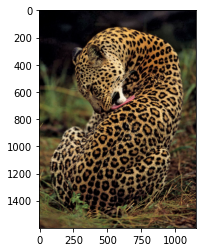

In [20]:
makePrediction(model, 'https://cdn.britannica.com/30/136130-050-3370E37A/Leopard.jpg')


Prediction 1 : watch, Score: 94.15780305862427%
Prediction 2 : Leopards, Score: 1.5316619537770748%
Prediction 3 : airplanes, Score: 1.4019676484167576%


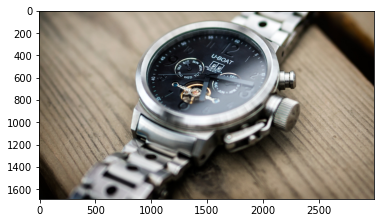

In [21]:
makePrediction(model, 'https://images.pexels.com/photos/164641/pexels-photo-164641.jpeg?cs=srgb&dl=silver-link-bracelet-black-u-boat-chronograph-watch-164641.jpg&fm=jpg')


In [0]:
!tar -czf model.tar.gz model_0.pth
